<b><h1><center>Convolution Neural Network (using Dataset = MNIST --> Hand Written Digits)

<b><h2>Importing Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import math
from datetime import timedelta

<b><h2>Importing Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


<b><h2>Printing Data Sizes (Training, Test, Validation)

In [4]:
print("Size of:")
print("Training Sets:\t\t{}".format(len(data.train.labels)))
print("Test Sets:\t\t{}".format(len(data.test.labels)))
print("Validation Sets:\t{}".format(len(data.validation.labels)))

Size of:
Training Sets:		55000
Test Sets:		10000
Validation Sets:	5000


<b><h2>Converting Classes of Test Set from "One-Hot Encoding" into an Integer

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

<b><h2>Initializing Parameters for Future Use

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10
num_channels = 1

<b><h2>Helper Function to Plot Images

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

<b><h2>Checking and Plotting True Classes of a few Images

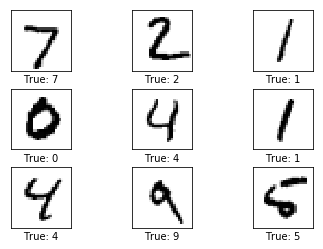

In [8]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

<b><h2>Helper Functions to Create Variables for Weights and Biases for Further Use

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

<b><h2>Helper Function to Create a Convolutional Layer

In [10]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME')
    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
    layer = tf.nn.relu(layer)
    
    return layer, weights

<b><h2>Helper Function to Flatten the Layer

In [11]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

<b><h2>Helper Function to Create a Fully-Connected Layer

In [12]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

<b><h2>Creating Placeholders for Images and their Classes

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat])
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes])
y_true_cls = tf.argmax(y_true, axis=1)

<b><h2>Initialing Layer Parameters (including layer size, filter size, number of filters)

In [14]:
filter_size1 = 5
num_filters1 = 16
filter_size2 = 5
num_filters2 = 36
fc_size = 128

<b><h2>Creating 1st Convolutional Layer

In [15]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

In [16]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [17]:
weights_conv1

<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>

<b><h2>Creating 2nd Convolutional Layer

In [18]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)

In [19]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [20]:
weights_conv2

<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>

<b><h2>Flattening the Layer

In [21]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [23]:
num_features

1764

<b><h2>Creating 1st Fully Connected Layer

In [24]:
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

<b><h2>Creating 2nd Fully Connected Layer

In [26]:
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

<b><h2>Predicting Image Class from the last Layer (2nd FC-Layer) in the Model

In [28]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

<b><h2>Calculating Cost

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



<b><h2>Creating Optimizer

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

<b><h2>Calculating Accuracy of the Model

In [31]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

<b><h2>Creating Tensorflow Session and Initializing all Global Variables

In [32]:
session = tf.Session()
session.run(tf.global_variables_initializer())

<b><h2>Initializing Batch Size for Mini-Batch Optimization

In [33]:
train_batch_size = 64

<b><h2>Helper Function for Optimization with a Number of Iterations

In [34]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations+num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x:x_batch, y_true:y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Iteration: {0:>6}, Accuracy: {1:>6.1%}".format(i+1, acc))
            
    total_iterations += num_iterations
    
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time Taken: " + str(timedelta(seconds=int(round(time_dif)))))

<b><h2>Helper Function for Plotting a few Errors

In [35]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

<b><h2>Helper Function for Plotting Confusion Matrix

In [36]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<b><h2>Helper Function for Printing Accuracy of the Model on Test Set

In [37]:
test_batch_size = 256
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    while i < num_test:
        j = min(i+test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x:images, y_true:labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    print("Accuracy on Test Set: {0:.1%} ({1} / {2})".format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
        
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

<b><h2>Testing Accuracy on the Test Set without Traning the Model

In [38]:
print_test_accuracy()

Accuracy on Test Set: 9.8% (980 / 10000)


<b><h2>Training Model with Single Iteration and Checking Accuracy on Test Set

In [39]:
optimize(num_iterations=1)

Iteration:      1, Accuracy:   4.7%
Time Taken: 0:00:01


In [40]:
print_test_accuracy()

Accuracy on Test Set: 10.8% (1084 / 10000)


<b><h2>Training Model with 99 more Iterations and Checking Accuracy on Test Set

In [41]:
optimize(num_iterations=99)

Time Taken: 0:00:15


Accuracy on Test Set: 62.8% (6280 / 10000)
Example errors:


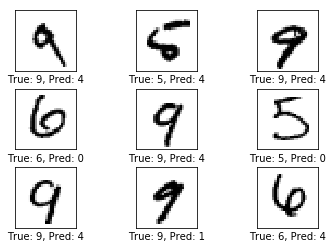

In [42]:
print_test_accuracy(show_example_errors=True)

<b><h2>Training Model with 900 more Iterations and Checking Accuracy on Test Set

In [43]:
optimize(num_iterations=900)

Iteration:    101, Accuracy:  64.1%
Iteration:    201, Accuracy:  81.2%
Iteration:    301, Accuracy:  71.9%
Iteration:    401, Accuracy:  85.9%
Iteration:    501, Accuracy:  93.8%
Iteration:    601, Accuracy:  87.5%
Iteration:    701, Accuracy:  87.5%
Iteration:    801, Accuracy:  90.6%
Iteration:    901, Accuracy:  89.1%
Time Taken: 0:02:15


Accuracy on Test Set: 93.3% (9332 / 10000)
Example errors:


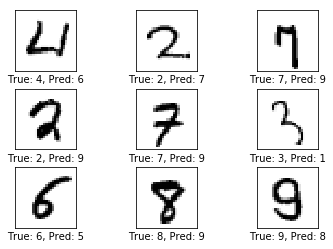

In [44]:
print_test_accuracy(show_example_errors=True)

<b><h2>Training Model with 9000 more Iterations and Checking Accuracy on Test Set

In [45]:
optimize(num_iterations=9000)

Iteration:   1001, Accuracy:  89.1%
Iteration:   1101, Accuracy:  95.3%
Iteration:   1201, Accuracy:  90.6%
Iteration:   1301, Accuracy:  95.3%
Iteration:   1401, Accuracy:  93.8%
Iteration:   1501, Accuracy:  93.8%
Iteration:   1601, Accuracy:  98.4%
Iteration:   1701, Accuracy:  93.8%
Iteration:   1801, Accuracy:  95.3%
Iteration:   1901, Accuracy:  95.3%
Iteration:   2001, Accuracy: 100.0%
Iteration:   2101, Accuracy:  95.3%
Iteration:   2201, Accuracy:  98.4%
Iteration:   2301, Accuracy:  93.8%
Iteration:   2401, Accuracy:  96.9%
Iteration:   2501, Accuracy:  95.3%
Iteration:   2601, Accuracy:  95.3%
Iteration:   2701, Accuracy:  98.4%
Iteration:   2801, Accuracy:  96.9%
Iteration:   2901, Accuracy:  96.9%
Iteration:   3001, Accuracy: 100.0%
Iteration:   3101, Accuracy:  96.9%
Iteration:   3201, Accuracy:  98.4%
Iteration:   3301, Accuracy:  98.4%
Iteration:   3401, Accuracy:  98.4%
Iteration:   3501, Accuracy:  98.4%
Iteration:   3601, Accuracy: 100.0%
Iteration:   3701, Accuracy:

Accuracy on Test Set: 98.6% (9861 / 10000)
Example errors:


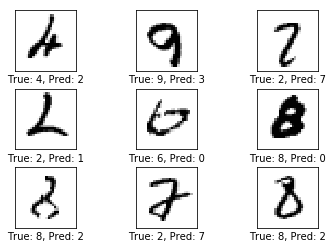

Confusion Matrix:
[[ 975    1    0    0    0    0    1    1    2    0]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   2    5 1019    0    1    0    0    4    1    0]
 [   0    0    1  997    0    6    0    3    3    0]
 [   1    0    2    0  974    0    1    3    1    0]
 [   1    0    0    1    0  887    1    2    0    0]
 [   4    3    0    0    1    6  944    0    0    0]
 [   0    1    3    0    0    0    0 1023    1    0]
 [   5    2    5    2    1    2    1    5  949    2]
 [   4    5    1    6    9    6    0   15    3  960]]


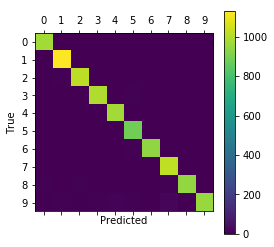

In [46]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

<b><h2>Helper Function for Plotting Convolutional Layer Weights

In [47]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

<b><h2>Helper Function for Plotting Image after the Corresponding Convolutional Layer is Applied

In [48]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

<b><h2>Helper Function for Plotting a Single Image

In [49]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape), interpolation='nearest', cmap='binary')
    plt.show()

<b><h2>Plotting Single Images

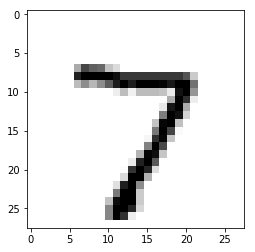

In [50]:
image1 = data.test.images[0]
plot_image(image1)

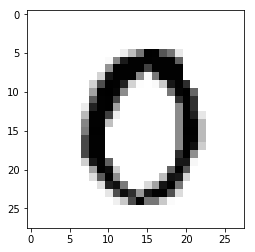

In [51]:
image2 = data.test.images[13]
plot_image(image2)

<b><h2>Plotting Weights of a Convolutional Layer along with an Image after Applying that Layer

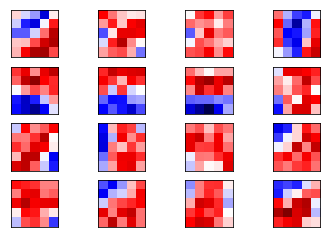

In [52]:
plot_conv_weights(weights=weights_conv1)

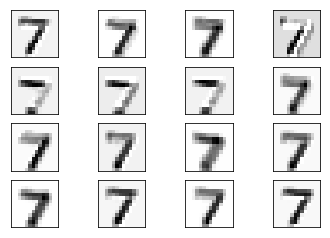

In [53]:
plot_conv_layer(layer=layer_conv1, image=image1)

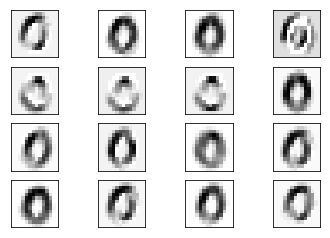

In [54]:
plot_conv_layer(layer=layer_conv1, image=image2)

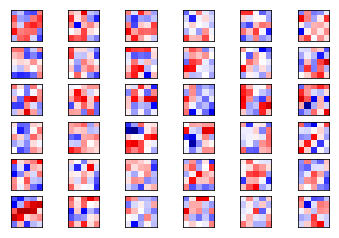

In [55]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

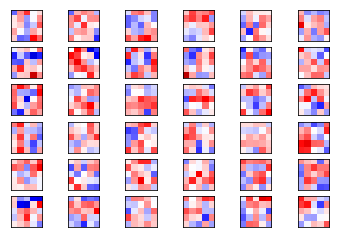

In [56]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

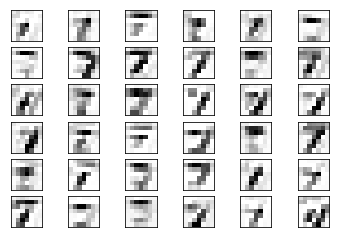

In [57]:
plot_conv_layer(layer=layer_conv2, image=image1)

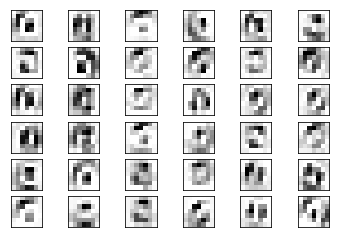

In [58]:
plot_conv_layer(layer=layer_conv2, image=image2)

<b><h2>Closing Tensorflow Session

In [59]:
session.close()

<b><h1><center>!---The End---!